In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#### Read in movie_genres.csv
movie_genre_df = pd.read_csv("movie_genres.csv", header=None, on_bad_lines='skip')
movie_genre_df.fillna(0, inplace=True)

movie_titles = []
movie_features = []

for i in range(1, movie_genre_df.shape[0]):
    movie_titles.append(movie_genre_df.iloc[i, 1])

for i in range(2, movie_genre_df.shape[1]):
    movie_features.append(movie_genre_df.iloc[0, i])

movie_genre_array = movie_genre_df.iloc[1:, 2:].to_numpy().astype(int)
print(movie_genre_array.shape)

(2000, 25)


In [3]:
### Read in user_reviews.csv
user_review_df = pd.read_csv("user_reviews.csv", header=None, on_bad_lines='skip', low_memory=False)
user_review_df.fillna(0, inplace=True)
user_names = []

for i in range(1, user_review_df.shape[0]):
    user_names.append(user_review_df.iloc[i, 1])

user_review_df = user_review_df.iloc[1:, 2:].astype(float)
user_review_array = user_review_df.to_numpy().astype(int)
print(user_review_array.shape)

(600, 2000)


In [4]:
reviews_dict = {1:0, 2:0, 3:0, 4:0, 5:0}
n_reviews = 0
total_reviews = len(user_names) * len(movie_titles)

for row in range(user_review_array.shape[0]):
    for col in range(user_review_array.shape[1]):
        if user_review_array[row, col] in reviews_dict:
            reviews_dict[user_review_array[row, col]] += 1
            n_reviews += 1
        
average_rating = sum(i * reviews_dict[i] for i in range(1, 6)) / n_reviews
print("Averege rating: " + str(average_rating))
print("Percentage of reviews: " + str(100* n_reviews / total_reviews) + " %")

Averege rating: 3.434069591527988
Percentage of reviews: 1.3770833333333334 %


In [5]:
def get_avg_user_rating(matrix):
    avg_user_rating = []
    for row in range(matrix.shape[0]):
        n_entries = 0
        sum_ratings = 0
        for col in range(matrix.shape[1]):
            if matrix[row, col] !=0:
                n_entries += 1
                sum_ratings += matrix[row, col]
        avg_user_rating.append(float(sum_ratings / n_entries))
    return avg_user_rating

def normalize_mean_zero(A, user_means):
    A = A.astype(float) 
    for row in range(A.shape[0]):
        A[row, A[row, :] != 0] -= user_means[row]
    return A

In [6]:
# Seen movies
user_id = 2
seen_movies = np.where(user_review_array[user_id] != 0)[0]
seen_movie_ratings = user_review_array[user_id, seen_movies]

for i, movie_index in enumerate(seen_movies):
    print(f"{movie_titles[movie_index]} - Rating: {seen_movie_ratings[i]}")

The Magic Sword: Quest for Camelot - Rating: 5
Veronica Guerin - Rating: 3
The Pursuit of D.B. Cooper - Rating: 2
The Purge: Anarchy - Rating: 2
Knight and Day - Rating: 4
Neighbors - Rating: 5
The Frozen - Rating: 4
2:13 - Rating: 3
Jonah: A VeggieTales Movie - Rating: 5
Dirty Work - Rating: 5
The Masked Saint - Rating: 3
Snow White: A Tale of Terror - Rating: 3
Jersey Girl - Rating: 4
Bend It Like Beckham - Rating: 4
Up Close & Personal - Rating: 3
Friday the 13th Part VII: The New Blood - Rating: 3
Get Hard - Rating: 4
8MM - Rating: 2
I, Frankenstein - Rating: 3
That Thing You Do! - Rating: 5
Dysfunctional Friends - Rating: 4
The Secret Life of Walter Mitty - Rating: 4
Idiocracy - Rating: 4
The Knife of Don Juan - Rating: 5
No Vacancy - Rating: 2
Team America: World Police - Rating: 5
Bedtime Stories - Rating: 5
A Sound of Thunder - Rating: 4
The Big Wedding - Rating: 3
The Replacements - Rating: 3
From Paris with Love - Rating: 2
The Informant! - Rating: 4
Danny Collins - Rating: 5

In [7]:
######## Content Filtering
averege_user_ratings = get_avg_user_rating(user_review_array)
normalized_array = normalize_mean_zero(user_review_array.copy(), averege_user_ratings)
genre_scores = normalized_array @ movie_genre_array

def get_top_n_content_filtering(user, n_top):
    predicted_genre = genre_scores[user]

    unrated_movies = np.where(normalized_array[user] == 0.0)[0]

    movie_genre_scores = movie_genre_array[unrated_movies] # acess is rows since its an array...

    predicted_ratings = movie_genre_scores @ predicted_genre.T 

    top_movies_index = np.argsort(predicted_ratings)[::-1] 

    return top_movies_index[:n_top]

users = [0,1,2,3,4]

movie_titles = movie_genre_df.iloc[1:, 1].tolist()
for user in users:
    top_for_user = get_top_n_content_filtering(user, 5)
    
    
    print(user_names[user])
    for i, movie_id in enumerate(top_for_user):
        if movie_id < len(movie_titles):

            print("Recommendation " + str(i+1) + ": " +  movie_titles[movie_id])

Vincent
Recommendation 1: The Sweet Hereafter
Recommendation 2: 88 Minutes
Recommendation 3: Farce of the Penguins
Recommendation 4: Whatever Works
Recommendation 5: The Adventures of Sharkboy and Lavagirl 3-D
Edgar
Recommendation 1: Domestic Disturbance
Recommendation 2: Minions
Recommendation 3: Hollywood Ending
Recommendation 4: 12 Rounds
Recommendation 5: Western Religion
Addilyn
Recommendation 1: Glory Road
Recommendation 2: Herbie Fully Loaded
Recommendation 3: The Last Song
Recommendation 4: Beverly Hills Chihuahua
Recommendation 5: Dracula 2000
Marlee
Recommendation 1: Along the Roadside
Recommendation 2: Minions
Recommendation 3: Friends with Benefits
Recommendation 4: Duets
Recommendation 5: Transsiberian
Javier
Recommendation 1: Raging Bull
Recommendation 2: Homefront
Recommendation 3: Van Wilder: Party Liaison
Recommendation 4: Monsoon Wedding
Recommendation 5: The Case of the Grinning Cat


In [8]:
### Collaborative filtering using matrix factorization and Alternating least Squares begins here

def objective_value_MF(A, U, V, reg):
    tot_sum = 0

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] != 0:  
                tot_sum += (A[i, j] - np.dot(U[i], V[j])) ** 2
    
    tot_sum += reg * (np.sum(U ** 2) + np.sum(V ** 2))

    return tot_sum

def evaluate_rmse(A, predict_A):
    n_reviews = 0
    sum_squared_error = 0

    for row in range(A.shape[0]):
        for col in range(A.shape[1]):
            if A[row, col] != 0:  
                n_reviews += 1
                sum_squared_error += (A[row, col] - predict_A[row, col]) ** 2

    return np.sqrt(sum_squared_error / n_reviews)  

def matrix_factorization_ALS(A, U, V, reg, iterations):
    n_users = A.shape[0]
    n_movies = A.shape[1]
    dim = U.shape[1]
    objective_values = []
    errors = []

    for _ in range(iterations):
        for user_index in range(n_users):
            rated_movies = np.where(A[user_index, :] != 0)[0] 
            V_rated = V[rated_movies] 

            inverse = np.linalg.inv(V_rated.T @ V_rated + reg * np.identity(dim))
            result = inverse @ V_rated.T @ A[user_index, rated_movies]
            U[user_index] = result
            
        for movie_index in range(n_movies):
            rated_users = np.where(A[:, movie_index] != 0)[0]
            U_rated = U[rated_users]  

            inverse = np.linalg.inv(U_rated.T @ U_rated + reg * np.identity(dim))
            result = inverse @ U_rated.T @ A[rated_users, movie_index]
            V[movie_index] = result

        objective_values.append(objective_value_MF(A, U, V, reg))
        errors.append(evaluate_rmse(A, U @ V.T))

    Y_predict = U @ V.T
    return Y_predict, objective_values, errors

In [12]:
# A: user reviews imported earlier
# U: embedding matrix where each row is a user, times dimension d
# V: embedding matrix where each row is a product, time a dimension d

np.random.seed(10) 

### Hyper-parameters
reg = 1
embedd_dimensions = [40, 50]
iterations = 150

A = normalize_mean_zero(user_review_array.copy(), averege_user_ratings)

results = {}

results[reg] = {"errors": [], "objectives": [], "final_rmse": []}

for dim in embedd_dimensions:
    U = np.random.normal(loc=0, scale=0.1, size=(A.shape[0], dim))
    V = np.random.normal(loc=0, scale=0.1, size=(A.shape[1], dim))
    Y_predict, objectives, errors = matrix_factorization_ALS(A.copy(), U.copy(), V.copy(), reg, iterations)
    averege_user_ratings = np.array(averege_user_ratings)
    Y_predict += averege_user_ratings[:, np.newaxis]
    final_rmse = evaluate_rmse(user_review_array, Y_predict)

    results[reg]["errors"].append(errors)
    results[reg]["objectives"].append(objectives)
    results[reg]["final_rmse"].append(final_rmse)

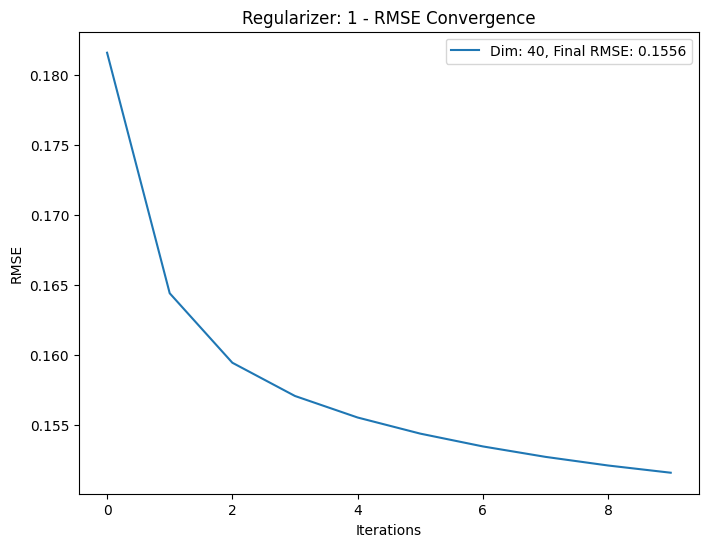

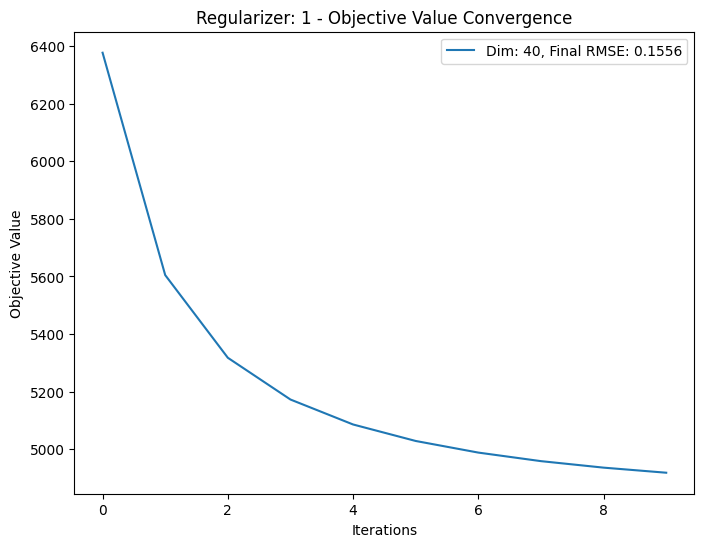

In [11]:
## plotting code
plt.figure(figsize=(8, 6))
for i, dim in enumerate(embedd_dimensions):
    plt.plot(results[reg]["errors"][i], label=f"Dim: {dim}, Final RMSE: {results[reg]['final_rmse'][i]:.4f}")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title(f"Regularizer: {reg} - RMSE Convergence")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, dim in enumerate(embedd_dimensions):
    plt.plot(results[reg]["objectives"][i], label=f"Dim: {dim}, Final RMSE: {results[reg]['final_rmse'][i]:.4f}")
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.title(f"Regularizer: {reg} - Objective Value Convergence")
plt.legend()
plt.show()

In [47]:
np.random.seed(10)

regularizer = 1
embedding_dimension = 40
iterations = 150

A = normalize_mean_zero(user_review_array.copy(), averege_user_ratings)

U = np.random.normal(loc=0, scale=0.1, size=(A.shape[0], embedding_dimension))
V = np.random.normal(loc=0, scale=0.1, size=(A.shape[1], embedding_dimension))

Y_predict, objectives, errors = matrix_factorization_ALS(A, U, V, regularizer, iterations)
averege_user_ratings = np.array(averege_user_ratings)
Y_predict += np.mean(user_review_array, axis=1, keepdims=True)

In [64]:
users = [0, 1, 2, 3, 4]

for user in users:
    top_for_user = Y_predict[user].copy()  
    watched_movies = np.where(A[user] != 0)[0] 
    top_for_user[watched_movies] = -np.inf  # the seen movies gets really low score
    top_movies_index = np.argsort(top_for_user)[-5:][::-1]
    
    for i in range(len(top_movies_index)):
        print(user_names[user] + " recommendation " + str(i+1) + " is " + movie_titles[top_movies_index[i]] + ". ")

Vincent recommendation 1 is The Heart of Me. 
Vincent recommendation 2 is Splice. 
Vincent recommendation 3 is Alpha and Omega 4: The Legend of the Saw Toothed Cave. 
Vincent recommendation 4 is Go for It!. 
Vincent recommendation 5 is Battle of the Year. 
Edgar recommendation 1 is Sweet Charity. 
Edgar recommendation 2 is Judgment at Nuremberg. 
Edgar recommendation 3 is Deadline Gallipoli. 
Edgar recommendation 4 is The Adventures of Tintin. 
Edgar recommendation 5 is Cinderella. 
Addilyn recommendation 1 is Lords of Dogtown. 
Addilyn recommendation 2 is Brazil. 
Addilyn recommendation 3 is Maid in Manhattan. 
Addilyn recommendation 4 is Fiddler on the Roof. 
Addilyn recommendation 5 is The Life Before Her Eyes. 
Marlee recommendation 1 is A Sound of Thunder. 
Marlee recommendation 2 is Red Sky. 
Marlee recommendation 3 is World War Z. 
Marlee recommendation 4 is The Astronaut's Wife. 
Marlee recommendation 5 is Marmaduke. 
Javier recommendation 1 is Not Another Teen Movie. 
Javier r